# Simple time calculation estimate - Large Cluster

Box:  4 mpc (covering basically the whole cluster or group).  2048$^3$ root grid, 4 nested grids (32,768$^3$ effective resolution).

These estimates are now MHD and include the AGN jet.

In [1]:
from unyt import pc, yr, K, kpc, Mpc, km, s, Myr, Gyr, K, cm, gauss, mp, kb, g, c
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
 color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def get_mesh_info(n_rg, n_mb, n_level, l_box, l_center, v100_cells=256):
    """
    Params:
      n_rg - root grid side length in number of cells
      n_mb - meshblock side  length in number of cells
      n_level - total number of levels (1 is root grid only)
      l_box - physical box size
      l_center - physical size of target central region
    
    Returns:
      num_blocks - total number of meshblocks
      dx_rg - physical box size on the root grid
      dx_center - physical box size in the central region
    """
    assert(n_level >= 1)
    assert(l_center < l_box)
    assert(n_rg % n_mb == 0)
    assert(v100_cells >= 64)
    
    dx_rg = l_box / n_rg
    dx_center = dx_rg / 2**(n_level - 1)
    
    
    print("Root {:04.3f}^3 covered by effective {:d}^3 grid. Root dx = {:04.3f}".format(
        l_box.to("kpc"),
        int(l_box/dx_center),
        dx_rg.to("kpc")))

    n_cells_center = l_center / dx_center
    n_meshblocks_center = np.ceil(n_cells_center/n_mb)
    # ensure factor of 2 (required in hierarchy)
    if (n_meshblocks_center % 2 != 0):
        n_meshblocks_center += 1
    l_center_blocks = n_meshblocks_center * n_mb * dx_center # region actually covered at highest level
    
    print("Central {:04.3f}^3 covered by {:d}^3 grid with dx = {:04.3f}".format(
        l_center_blocks.to("kpc"),
        int(n_meshblocks_center * n_mb),
        dx_center.to("kpc")))
    
    num_meshblocks = np.zeros((n_level), dtype=int)
    num_meshblocks[n_level-1] = int(n_meshblocks_center**3)
    
    # now cover transition regions (already including the central region as start)
    l_transitions = [l_center_blocks]
    for level in range(1, n_level-1):
        dx_this_level = dx_center*2**level
        l_transitions.append(l_transitions[-1] + 2*n_mb * dx_this_level)
        n_meshblocks_this_level = l_transitions[-1] / dx_this_level / n_mb        
        num_meshblocks[n_level-1 - level] = int(n_meshblocks_this_level**3 -  (n_meshblocks_this_level - 2)**3)
    l_transitions.reverse()
    
    n_meshblocks_first_level_at_dx_rg = l_transitions[0] / dx_rg / n_mb
    num_meshblocks[0] = int( (n_rg / n_mb)**3 - n_meshblocks_first_level_at_dx_rg**3)
    
    for i in range(1,n_level+1):
        print("Level {:2d}: dx = {:04.3f} with {:6d} blocks".format(
            i,
            (dx_rg / 2**(i - 1)).to("kpc"),
            num_meshblocks[i-1]
        ))
    print("Total number of blocks: {:d}".format(np.sum(num_meshblocks)))
    
    #print("Total number of cells: {:.3e}".format(N_cells_total))

    
    cells_per_V100_base = v100_cells**3
    blocks_per_V100_actual = cells_per_V100_base / n_mb**3
    assert(blocks_per_V100_actual >= 1.0)
    
    num_gpus_min = int(np.ceil(np.sum(num_meshblocks) / blocks_per_V100_actual))
    print("Need at least {:d} V100 GPUs, i.e., {:d} Summit nodes".format(num_gpus_min, num_gpus_min//6))
    
    fig, ax = plt.subplots()
    # add root grid
    ax.add_patch(Rectangle(( - l_box.to("kpc")/2, - l_box.to("kpc")/2,),
                           l_box.to("kpc"), l_box.to("kpc"), color = color_list[0]))
    
    for i, l_transition in enumerate(l_transitions):
        ax.add_patch(Rectangle(( - l_transition.to("kpc")/2, - l_transition.to("kpc")/2,),
                               l_transition.to("kpc"), l_transition.to("kpc"), color = color_list[i+1]))       
    
    
    #ax.add_patch(Rectangle(( - l_center.to("kpc")/2, - l_center.to("kpc")/2,),
    #                       l_center.to("kpc"), l_center.to("kpc"), color=color_list[n_level - 1]))
    
    ax.set_xlim(- 1.1*l_box.to("kpc")/2, 1.1*l_box.to("kpc")/2)
    ax.set_ylim(- 1.1*l_box.to("kpc")/2, 1.1*l_box.to("kpc")/2)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel("box size [kpc]")
    ax.set_ylabel("box size [kpc]")
    plt.show()
    
    return num_gpus_min, np.sum(num_meshblocks), dx_center

### Physical parameters

In [5]:
Lbox =4*Mpc  # total box size
Lcenter = 0.25*Mpc # size of box at highest refinement level

rho = 1e-28 * g/cm**3
T_gas = 5.0e+6 * K # temperature of ambient cluster gas, approximately the temperature of a massive elliptical
                   # reasonable temps are 5e6 for center, 2e7 for group, 5e7 K for cluster
V_jet = 0.05 * c # simulated jet speed, units of speed of light
                 # should be 0.05 for nonrelativistic, 0.9 for relativistic

jet_duty_cycle = 0.25  # fraction of time that the jet is active (i.e., when jet is relevant)

T_sim = 400* Myr # total number of years for simulation

# mean molecular weight for ionized gas
mu = 0.6

gamma = 5./3.

c_s = np.sqrt(gamma * kb * T_gas / mu / mp )

# Magnetization
Mag = 1e-6 * gauss

# Alfven speed (cm/s)
v_A = Mag / (4.0*np.pi * rho)**0.5

# fast magnetosonic wave
v_FMS = ( 0.5*(c_s**2 + v_A**2) + ((c_s**2 + v_A**2)**2 -4*v_A**2*c_s**2)**0.5  )**0.5  


### Computational parameters

Root 4000.000 kpc^3 covered by effective 8192^3 grid. Root dx = 7.812 kpc
Central 250.000 kpc^3 covered by 512^3 grid with dx = 0.488 kpc
Level  1: dx = 7.812 kpc with    500 blocks
Level  2: dx = 3.906 kpc with     75 blocks
Level  3: dx = 1.953 kpc with     98 blocks
Level  4: dx = 0.977 kpc with    152 blocks
Level  5: dx = 0.488 kpc with    512 blocks
Total number of blocks: 1337
Need at least 2 V100 GPUs, i.e., 0 Summit nodes


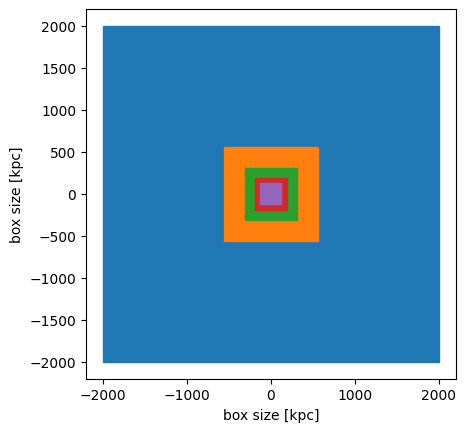

In [11]:
Nrg = 512    # size of root grid
meshblock_size = 64 # number of cells per side of each MeshBlock
Levels = 5    # number of levels including root level
Courant = 0.3  # 0 < C < 1 

cells_per_volta = 128*(4**(1./3))*48/16  # one side of the cube, total number is this cubed
                                         # this weird number assumes 4 128^3 blocks per Volta
                                         # further scaled by size of A40 memory

cell_updates_s_gpu = 2.0e+7  # cell updates per second per GPU, assuming physics, etc.

num_gpus, num_blocks, dx_fine =  get_mesh_info(Nrg, meshblock_size, Levels, Lbox, Lcenter, cells_per_volta)


data_outputs = 200     # number of data outputs
number_of_fields = 9   # 3*velocity, density, internal energy, 3*b-field, 1*tracer field
bytes_per_field = 4    # how many bytes per word?  (4 or 8)
data_multiplier = 1.1  # if we only write out 4 bytes/field make this 1.1 (instead of 1.0)
                       # becasue we'll write some as 64-bit)

In [7]:
print("sound speed: {:04.2f}".format(c_s.to('km/s')))
print("Alfven speed: {:04.2f}".format(v_A.to('km/s')))
print("Fast magnetosonic speed: {:04.2f}".format(v_FMS.to('km/s')))
print("gas (jet) velocity {:04.2f}:".format(V_jet.to('km/s')))

# timestep in cm/s (hydro at the moment)
dt_jet = Courant * dx_fine / (v_FMS + V_jet)

dt_nojet = Courant * dx_fine / (v_FMS + c_s)

N_ts_exact = jet_duty_cycle*(T_sim/dt_jet) + (1.0-jet_duty_cycle)*(T_sim/dt_nojet)

dt_mean = T_sim/N_ts_exact

print("jet timestep: {:04.2f}:".format(dt_jet.to('yr')))
print("no jet timestep: {:04.2f}:".format(dt_nojet.to('yr')))
print("mean timestep: {:04.2f}:".format(dt_mean.to('yr')))
print("exact # of time steps: {:.2f}".format(N_ts_exact))

# number of time steps, approximately
N_ts = int(T_sim / dt_mean)

print("number of time steps {:d} to go this many years: {:04.2f}:".format( N_ts, T_sim.to('Myr')))

sound speed: 338.59 km/s
Alfven speed: 282.09 km/s
Fast magnetosonic speed: 363.56 km/s
gas (jet) velocity 14989.62 km/s:
jet timestep: 9329.09 yr:
no jet timestep: 203988.32 yr:
mean timestep: 32814.24 yr:
exact # of time steps: 12189.83 dimensionless
number of time steps 12189 to go this many years: 400.00 Myr:


In [8]:
# calculate how many cells we're going to use for the whole simulation
N_cells_total = num_blocks * meshblock_size**3
        
print("total cells: {:.3e}".format(N_cells_total))

# how many total cell updates? (number of timesteps) x (number of cells)
total_cell_updates = N_ts * N_cells_total

print("total cell-updates: {:.3e}".format(total_cell_updates))

total cells: 3.505e+08
total cell-updates: 4.272e+12


Summet has 6 V100s GPUs per node; how many node-hours?  If we ran on user-specified number of nodes, how many wall clock hours?

In [9]:

node_hours = total_cell_updates / (cell_updates_s_gpu * 6) / 3600.

print("total Summit node-hours per simulation: {:.1f} K".format(node_hours/1000))
N_nodes = int(np.ceil(num_gpus / 6))
wall_clock_hours = node_hours / N_nodes

print("total Summit wall clock hours per simulation: {:.2f}  (assuming {:d} nodes)".format(wall_clock_hours, N_nodes))


total Summit node-hours per simulation: 0.0 K
total Summit wall clock hours per simulation: 1.41  (assuming 7 nodes)


In [10]:
dt_data_dump = T_sim / data_outputs

print("data outputted every {:.2f}".format(dt_data_dump.to('Myr')))

data_per_output = N_cells_total * number_of_fields * bytes_per_field * data_multiplier

total_data_volume = data_outputs * data_per_output

print("avg. size of 1 data output: {:.3e} (TB)".format(data_per_output/1.e12))

print("total data volume:          {:.3e} (TB)".format(total_data_volume/1.e12))

data outputted every 2.00 Myr
avg. size of 1 data output: 1.388e-02 (TB)
total data volume:          2.776e+00 (TB)
